Transformer Encoder

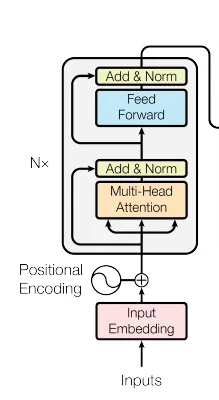

In [59]:
import torch
import torch.nn as nn
import numpy as np
import math
import torch.nn.functional as F

## Setting The Hyperprameters

In [60]:
batch_size = 32
max_seq_len = 64
input_dim = 512
d_model = 512
num_heads = 8
ffn_hidden = 2048
num_layers = 6
dropout_rate = 0.2

## Multi-head Self-Attention

In [61]:
def scaled_dot_product_attention(q,k,v,mask=None):
    d_k = q.size(-1)
    qk = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None and mask is True:
        mask = torch.full(qk.size(),fill_value= float('-inf'))
        mask = torch.triu(mask, diagonal=1)
        qk = qk + mask 
    qk = F.softmax(qk, dim=-1)
    new_qkv = torch.matmul(qk, v)
    return new_qkv

class MultiheadAttention(nn.Module):
    def __init__(self,input_dim, d_model, num_heads):
        super(MultiheadAttention, self).__init__()
        self.input_dim = input_dim
        self.model_dim = d_model
        self.num_heads = num_heads
        self.head_dim = self.model_dim // self.num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * self.model_dim)
        self.concat_layer = nn.Linear(self.model_dim, self.model_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,x,mask=None):
        qkv = self.qkv_layer(x)
        qkv = qkv.view(batch_size,max_seq_len,self.num_heads,3*self.head_dim)
        qkv = qkv.permute(0,2,1,3)
        q,k,v = qkv.chunk(3,dim=-1)
        new_qkv = scaled_dot_product_attention(q,k,v,mask)
        new_qkv = new_qkv.view(batch_size,max_seq_len,self.model_dim)
        out = self.concat_layer(new_qkv)
        return out

## Positional Encoding

In [62]:
class PostionalEncoding(nn.Module):
    def __init__(self,max_seq_len,d_model):
        super(PostionalEncoding,self).__init__()
        self.max_seq_len = max_seq_len
        self.d_model = d_model
        self.encoding = torch.zeros(self.max_seq_len,self.d_model)
    
    def forward(self,x):
        even_index = torch.arange(0,self.d_model,2).float()
        domenator = torch.pow(10000,even_index/self.d_model)
        position = torch.arange(0,self.max_seq_len).unsqueeze(1)
        PE_even = torch.sin(position/domenator)
        PE_odd = torch.cos(position/domenator)
        stacked = torch.stack([PE_even,PE_odd],dim=2)
        PE_flatten = torch.flatten(stacked,start_dim=1,end_dim=2)
        return PE_flatten

## Normalization Layer

In [63]:
class NormalizationLayer():
    def __init__(self,parameter_dim):
        super(NormalizationLayer,self).__init__()
        self.parameters_shape = parameter_dim
        self.gamma = nn.Parameter(torch.ones(parameter_dim))
        self.beta = nn.Parameter(torch.zeros(parameter_dim))
        self.eps = 1e-6

    def forward(self,x):
        dims = [-(i + 1) for i in range(len(self.parameters_shape))]
        mean = x.mean(dims,keepdim=True)
        std = x.std(dims,keepdim=True)
        out =  self.gamma * (x - mean) / (std + self.eps) + self.beta
        return out

## Position-wise Feed-Forward

In [64]:
class FeedForward(nn.Module):
    def __init__(self,d_model,ffn_hidden):
        super(FeedForward,self).__init__()
        self.d_model = d_model
        self.ffn_hidden = ffn_hidden
        self.layer1 = nn.Linear(self.d_model,self.ffn_hidden)
        self.layer2 = nn.Linear(self.ffn_hidden,self.d_model)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self,x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x

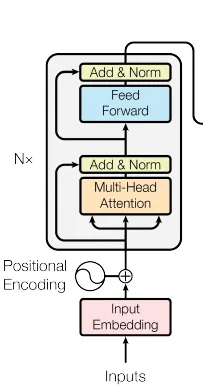

In [65]:
class Encoder_Layer(nn.Module):
    def __init__(self,num_heads, d_model, ffn_hidden, max_seq_len, dropout_rate):
        super(Encoder_Layer,self).__init__()
        self.multihead_attention = MultiheadAttention(input_dim,d_model,num_heads)
        self.pos_encoding = PostionalEncoding(max_seq_len,d_model)
        self.feedforward = FeedForward(d_model,ffn_hidden)
        self.norm1 = NormalizationLayer(d_model)
        self.norm2 = NormalizationLayer(d_model)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
    
    def forward(self,x):
        x = self.pos_encoding(x)
        reseduial_x = x
        x = self.multihead_attention(x)
        x = self.dropout1(x)
        x = x + reseduial_x
        x = self.norm1(x)
        reseduial_x = x
        x = self.feedforward(x)
        x = self.dropout2(x)
        x = x + reseduial_x
        x = self.norm2(x)
        return x

In [66]:
class Ecoder(nn.Module):
    def __init__(self, d_model, ffn_hidden, num_heads, dropout_rate, num_layers):
        super().__init__()
        self.layers = nn.Sequential(*[Encoder_Layer(num_heads, d_model, ffn_hidden, max_seq_len, dropout_rate)
                                     for _ in range(num_layers)])
    def forward(self, x):
        x = self.layers(x)
        return x

In [67]:
x = torch.randn(batch_size,max_seq_len,input_dim)
encoder = Ecoder(d_model, ffn_hidden, num_heads, dropout_rate, num_layers)
out = encoder(x)
print(out.shape)
out

RuntimeError: shape '[32, 64, 8, 192]' is invalid for input of size 98304